In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

### Problem 2a

In [249]:
vaccine_date = pd.read_csv("/Users/mengtonghu/Downloads/Vaccine_state_10112021.csv")
confirmed_county = pd.read_csv("/Users/mengtonghu/Downloads/Confirmed_county_101221.csv")
Michigan_pop = int(vaccine_date[vaccine_date['Province_State'] == "Michigan"]['Population'].sum())
vaccine_date_1 = vaccine_date[vaccine_date['Province_State'] == "Michigan"]
confirmed_county_1 = confirmed_county[confirmed_county['Province_State'] == "Michigan"]
confirmed_county_1 = confirmed_county_1.groupby('Province_State').sum()
np.where(confirmed_county_1.columns.values=="11/16/20")
confirmed_county_1 = confirmed_county_1.iloc[:,304:(confirmed_county_1.shape[1]+1)]
vaccine_date_1 = vaccine_date_1.iloc[:,12:(vaccine_date_1.shape[1]+1)]

In [250]:
vaccine_date_long = pd.melt(vaccine_date_1, var_name ='date', value_name='total vaccinated people')
vaccine_date_long['percent'] = (vaccine_date_long['total vaccinated people'] / Michigan_pop) *100
_ = pd.to_datetime(vaccine_date_long['date'])
confirmed_county_long = pd.melt(confirmed_county_1, var_name ='date', value_name='confirmed')
vaccine_date_long['date']= pd.to_datetime(vaccine_date_long['date'],format = '%Y-%m-%d')
confirmed_county_long['date']= pd.to_datetime(confirmed_county_long['date'],format = '%m/%d/%y')
merged = confirmed_county_long.merge(vaccine_date_long,how='left', left_on='date',right_on ='date')


In [251]:
weight = merged[merged['date'] == '2021-10-11']['percent']/68
merged['percent'] = merged['percent']/weight.values[0]

#### We need to reweight the perecent of vaccination to match the actual vaccinated population

In [252]:
print('To re-weight the percent of vacinnation I divided, the percent of vaccination using ',
      weight.values[0])

To re-weight the percent of vacinnation I divided, the percent of vaccination using  1.6074729958761271


In [253]:
merged[['confirmed_diff','percent_diff']] = merged[['confirmed','percent']].diff()

#### We need to find I_0 -  the perecent of vaccination to match the actual vaccinated population

In [254]:
I_0 = ((merged[merged['date']=='2020-11-29'].confirmed.values \
       - merged[merged['date']=='2020-11-23'].confirmed.values)\
       + merged[merged['date']=='2020-11-22'].confirmed.values\
        -merged[merged['date']=='2020-11-16'].confirmed.values )/2
       

print("The average weekly comfirmed cases 14 days prior to 2020-11-30 is ", I_0)

The average weekly comfirmed cases 14 days prior to 2020-11-30 is  [38627.5]


In [255]:
merged = merged[merged['date'] >= '2020-11-30']
merged = merged[merged['date'] != '2021-10-11']
merged_old = merged

#### Create weekly data - The weekly data by Mondays is grouped by daily data using the data in the past 7 days including the current day.

In [256]:
merged = merged.resample('W-MON', label='left', closed = 'left', on='date')\
.sum().reset_index().sort_values(by='date')

In [257]:
merged_old.drop(labels=['percent_diff','confirmed_diff'], axis=1,inplace=True)

In [258]:
diff = merged.resample('W-MON', label='left', closed = 'left', on='date')[
    'percent_diff',"confirmed_diff"].sum().reset_index().sort_values(by='date')

In [259]:
merged_old[['total vaccinated people','percent']] = merged_old[[
    'total vaccinated people','percent']].shift(1).values

In [260]:
merged = diff.merge(merged_old,how='left',left_on = 'date',right_on='date')

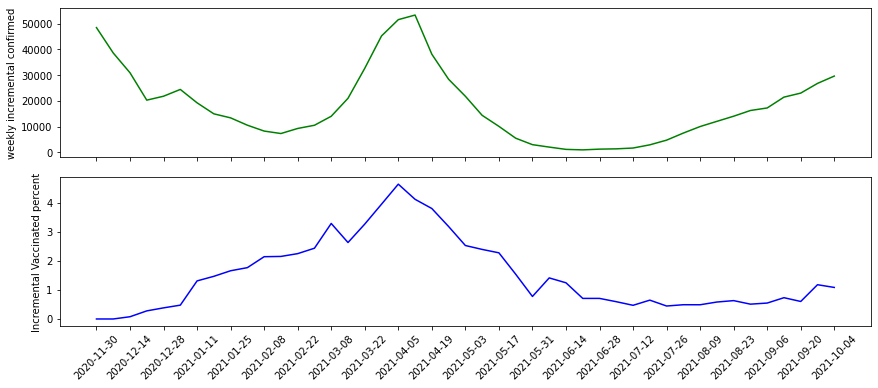

In [264]:
fig, axes = plt.subplots(figsize =(12, 5),nrows=2, ncols=1, sharex=True)
fig.tight_layout()

_ = axes[0].plot(merged['date'],merged['confirmed_diff'],color = 'green')
_ = axes[1].plot(merged['date'],merged['percent_diff'],color = 'blue')
for i, lab in enumerate(['weekly incremental confirmed', 'Incremental Vaccinated percent']):
    _ = axes[i].set_ylabel(lab)

axes[1].tick_params(axis='x', rotation=45)
_ = axes[1].set_xticks(merged['date'][::2])
plt.savefig("./covid_plot.png")

In [262]:
merged.to_csv("./Merged_covid_Data_new.csv", index=False)

There is no daily data for Recovery cases. Thus it is hard to visualize its trend. There doesn't seem to be any 'accute' effect or lagged pattern 